In [10]:
## test model behavior in synthetic/real images.
## found model output one certain value after training.
## test general mse value

import os
from model import *
from data_loader import *
from utils import *
import warnings
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
import toy_utils
import torch.nn.functional as F

def load_checkpoint(ckpt_path, model):
    
    ckpt_dir = 'ckpt/'+ckpt_path

    print("[*] Loading model from {}".format(ckpt_dir))

    filename = 'rfc_model_best.pth.tar'
    ckpt_path = os.path.join(ckpt_dir, filename)
    ckpt = torch.load(ckpt_path)

    # load variables from checkpoint
    start_epoch = ckpt['epoch']
    best_loss = ckpt['best_valid_mse']
    print("current epoch: {} --- best loss: {}".format(start_epoch, best_loss))
    model.load_state_dict(ckpt['model_state'])
    #optimizer.load_state_dict(ckpt['optim_state'])   

    return model


In [11]:
model = focusLocNet(0.17, 4, 256, 1).to("cuda:0")

In [12]:
model = load_checkpoint('0405_20_11', model)

[*] Loading model from ckpt/0405_20_11
current epoch: 67 --- best loss: 1.3822731771093866


In [13]:
model = model.eval()

# TEST MODEL BEHAVIOR

In [28]:
video_path = "../datasets/DAVIS/test_davis_video_list.txt"
depth_path = "../datasets/DAVIS/test_davis_dpt_list.txt"
video_dataset = load_davis_dataset(video_path, depth_path, 5)[0]
dataiter = iter(video_dataset)

torch.Size([1, 5, 3, 64, 128])


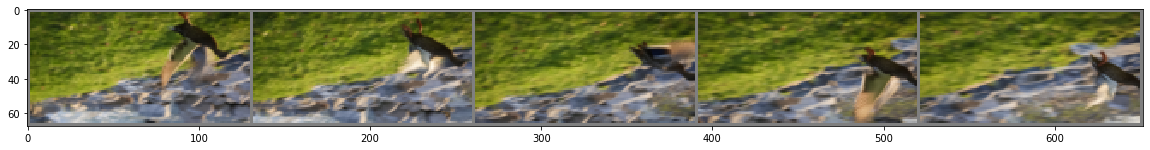

In [29]:
x_train, dpt = dataiter.next()
x_train = x_train.cuda()
dpt = dpt.cuda()
print(x_train.size())

# show images
imshow(torchvision.utils.make_grid(x_train[0]).cpu())

tensor([[-0.4338]], device='cuda:0')
tensor([[0.0609]], device='cuda:0')
tensor([[-0.0099]], device='cuda:0')
tensor([[-0.3842]], device='cuda:0')


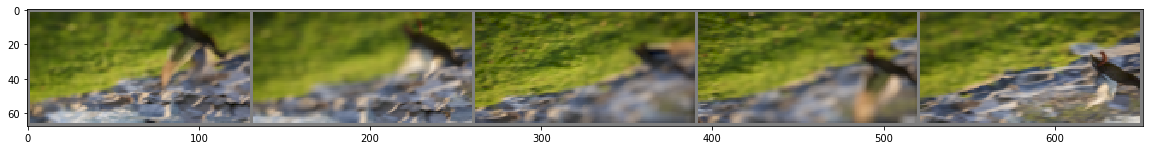

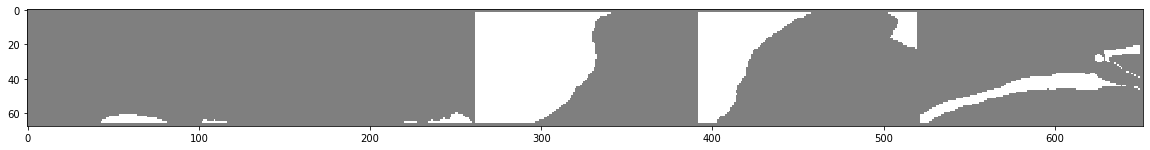

In [30]:
def reset():
    h = [torch.zeros(1, 1, 256).cuda(),
                  torch.zeros(1, 1, 256).cuda()]
    l = torch.rand(1, 1).cuda()-0.5 #-0.5~0.5
    return h, l

x_train = x_train.cuda()
dpt = dpt.cuda()
h, l = reset()

J_est = []
I_est = []
U_est = []
locs = []

I, _, u_in  = getDefocuesImage(l, x_train[:, 0, ...], dpt[:, 0, ...])
J_prev = I

I_est.append(I)
J_est.append(J_prev)
U_est.append(u_in)

locs.append(l)

with torch.no_grad():
    for t in range(x_train.size(1)-1):
        obs = toy_utils.calc_obs_input((dpt[:, t] - 4.0)/6.0, sum(locs))
        input_t = torch.cat([I, obs], dim = 1)

        h, mu, l, _, _ = model(input_t, l, h)
#                 l = torch.zeros(1, 1).cuda()
#                 l = torch.rand(1, 1).cuda()-0.5
        I, _, u_in = getDefocuesImage(sum(locs), x_train[:, t+1, ...], dpt[:, t+1, ...])
        J_prev = fuseTwoImages(I, J_prev)
        J_est.append(J_prev)
        I_est.append(I)
        U_est.append(u_in)
        
        locs.append(l)
        print(mu)

    J_est = torch.stack(J_est, dim = 1)
    I_est = torch.stack(I_est, dim = 1)
    U_est = torch.stack(U_est, dim = 1)
    locs = torch.stack(locs, dim = 1)
    
imshow(torchvision.utils.make_grid(I_est[0]).cpu())
imshow(torchvision.utils.make_grid(U_est[0]).cpu())

0.003951186314225197
0.003751029958948493


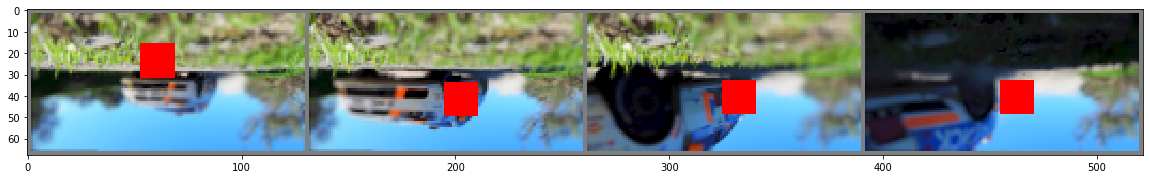

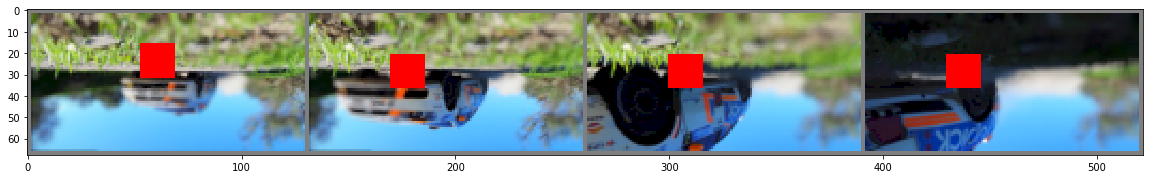

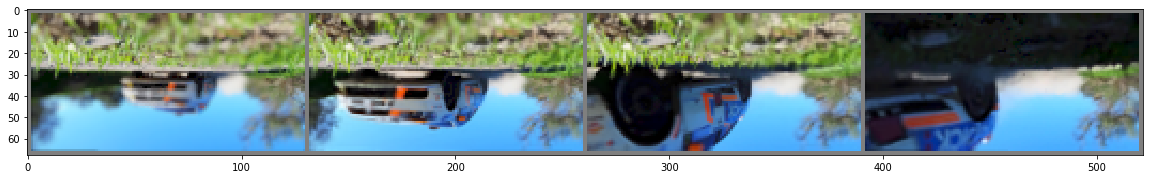

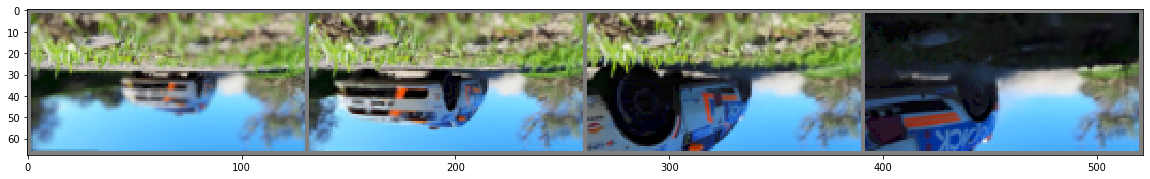

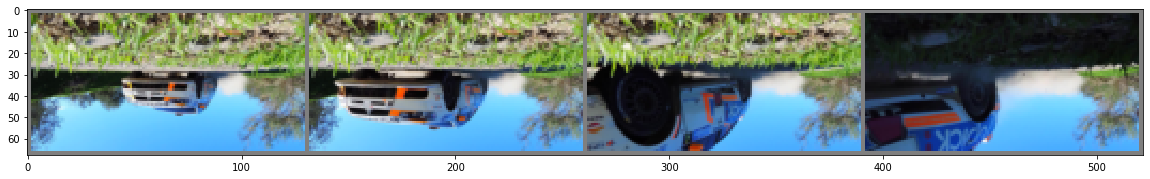

tensor([[-0.5415, -0.1946],
        [ 0.0046, -0.0015],
        [-0.0131, -0.0010],
        [-0.0252, -0.0033]], device='cuda:0')


In [51]:
%matplotlib inline
J_est = []
I_est = []
I_manual = []
J_manual = []
loc = []

l = torch.Tensor([[-0.5415, -0.1946]]).to("cuda:0")
# l_manual = torch.Tensor([[[-0.5415, -0.1946],
#         [-0.3933,  -0.396],
#         [-0.3933,  -0.396],
#         [-0.3933,  -0.396]]]).to("cuda:0")
I = getDefocuesImage(l, y_train[:, 0, ...], dpt[:, 0, ...])
J_prev = I
J_m = I

I_est.append(I)
I_manual.append(I)
J_est.append(J_prev)
J_manual.append(J_m)
loc.append(l)

with torch.no_grad():
    model.init_hidden()
    for t in range(y_train.size()[1]-1):
        mu, l, b, p = model(I, l)
        I = getDefocuesImage(mu, y_train[:, t+1, ...], dpt[:, t+1, ...])
        J_prev = fuseTwoImages(I, J_prev)
        J_est.append(J_prev)
        I_m = getDefocuesImage(l_manual[:, t+1], y_train[:, t+1, ...], dpt[:, t+1, ...])
        J_m = fuseTwoImages(I_m, J_m)
        J_manual.append(J_m)
        I_est.append(I)
        I_manual.append(I_m)
        loc.append(mu)
        
    J_est = torch.stack(J_est, dim = 1)
    I_est = torch.stack(I_est, dim = 1)
    J_manual = torch.stack(J_manual, dim = 1)
    I_manual = torch.stack(I_manual, dim = 1)


    loc = torch.stack(loc, dim = 1)
    R_i = reconsLoss(J_est[:, 1:], y_train[:, 1:])
    R_i = torch.mean(R_i, dim = 0)
    print(R_i.item())
    R_i = reconsLoss(J_manual[:, 1:], y_train[:, 1:])
    R_i = torch.mean(R_i, dim = 0)
    print(R_i.item())

imshow(torchvision.utils.make_grid(color_region(I_est[0], loc[0])).cpu())
imshow(torchvision.utils.make_grid(color_region(I_manual[0], l_manual[0])).cpu())
imshow(torchvision.utils.make_grid(J_est[0]).cpu())
imshow(torchvision.utils.make_grid(J_manual[0]).cpu())
imshow(torchvision.utils.make_grid(y_train[0]).cpu())
print(loc[0])

# REAL IMAGES TEST

tensor([[-0.5048,  0.2708]], device='cuda:0')


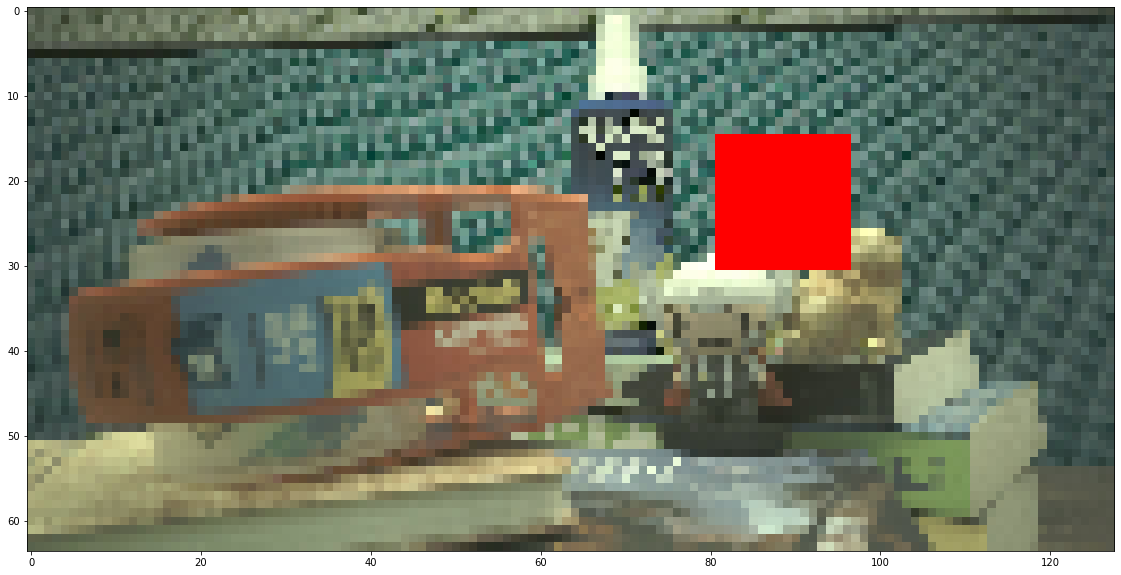

tensor([[-0.2438,  0.0557]], device='cuda:0')


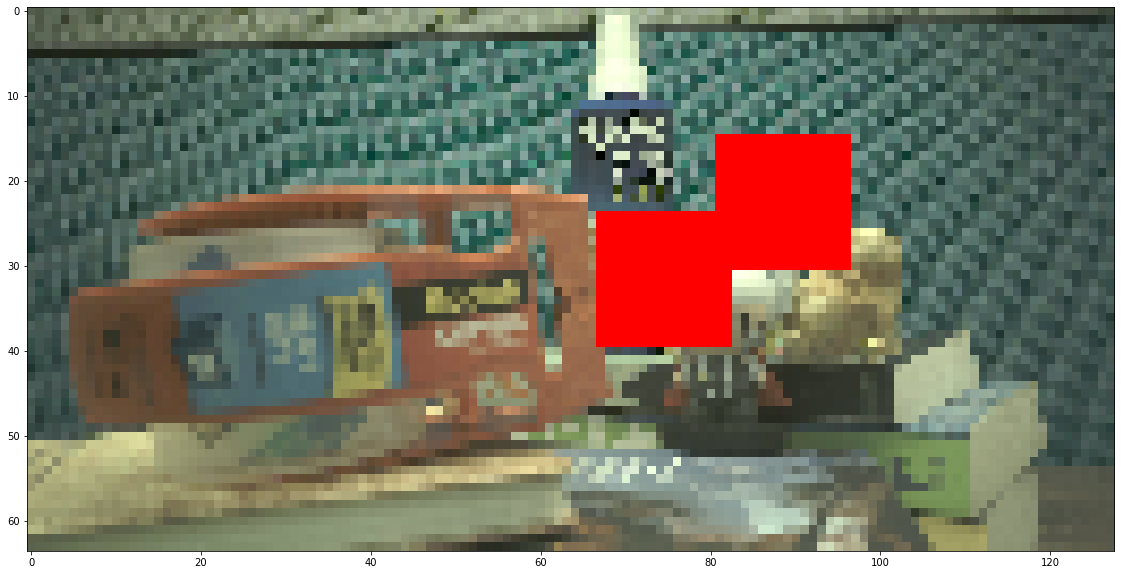

In [8]:
import cv2

l = torch.Tensor([[-0.5048,  0.2708]]).float().to(device = 'cuda:0')
print(l)
I = cv2.imread('/home/qian/Documents/pyFusion/test_files/68302_s550_01.jpg')
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
I = cv2.resize(I, (128, 64))
I = I.transpose(2, 0, 1)
I = torch.tensor(I/127.5 - 1, device="cuda:0").float().unsqueeze(0)
imshow(torchvision.utils.make_grid(color_region(I, l)).cpu())

with torch.no_grad():
    model.init_hidden()
    mu, l, b, p = model(I, l)
print(mu)

imshow(torchvision.utils.make_grid(color_region(I, mu)).cpu())

tensor([[0.5086, 0.7247]], device='cuda:0')


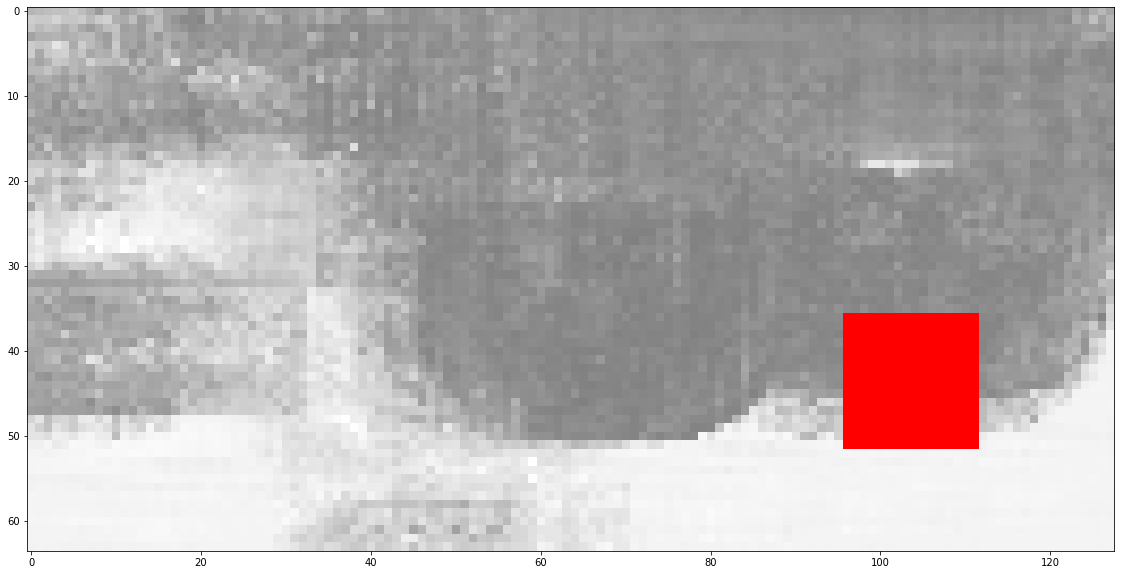

tensor(8., device='cuda:0') tensor(0.0242, device='cuda:0')
tensor([[0.5059, 0.7312]], device='cuda:0')


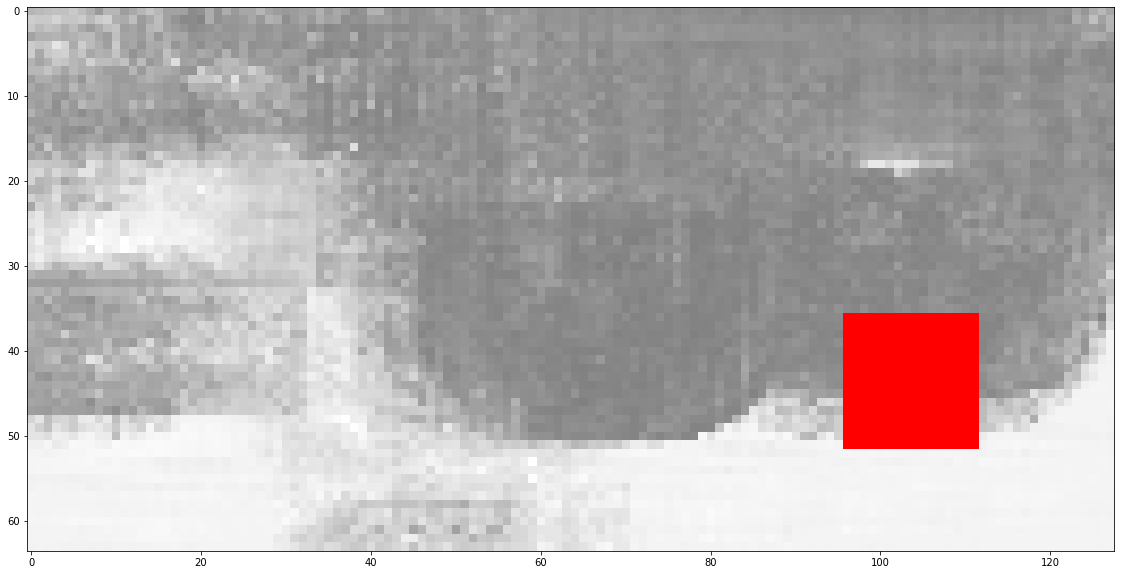

In [7]:
import cv2
l = torch.Tensor([[0.5086, 0.7247]]).float().to(device = 'cuda:0')
print(l)
I = np.load('../autofocus-stacking/static_fs/79854_s1000_02.npy')
I = cv2.resize(I, (128, 64))
I = torch.tensor(I, device="cuda:0").float().unsqueeze(0).unsqueeze(1)
I = torch.clamp(I, 0.0, 8.0)
imshow(torchvision.utils.make_grid(color_region(I.repeat(1, 3, 1, 1)/8.0, l)).cpu())
print(I.max(), I.min())

h = [torch.zeros(1, 1, 256).cuda(),
              torch.zeros(1, 1, 256).cuda()]
l = torch.rand(1, 2).cuda()*2-1


with torch.no_grad():
    h, mu, l, b, p = model(I, l, h)
print(mu)

imshow(torchvision.utils.make_grid(color_region(I.repeat(1, 3, 1, 1)/8.0, mu)).cpu())

# TEST SNR

In [9]:
## !! may need to change your dataloader
seq = 3
video_dataset, _ = load_davis_dataset(video_path, depth_path, seq, 1)

In [10]:
def reset():
    h = [torch.zeros(1, 1, 256).cuda(),
                  torch.zeros(1, 1, 256).cuda()]
    l = torch.rand(1, 1).cuda()-0.5 #-0.5~0.5
    return h, l

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
import toy_utils
import torch.nn.functional as F

class AverageMeter(object):
    """
    Computes and stores the average and
    current value.
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

losses = AverageMeter()
losses0 = AverageMeter()


for epoch in range(1):
    print("epoch:", epoch)
    for i, (x_train, dpt) in enumerate(video_dataset):
#         if i % 100 == 99:
#             print(i)
        x_train = x_train.cuda()
        dpt = dpt.cuda()
        h, l = reset()

        J_est = []
        I_est = []
        locs = []

        I, _, _  = getDefocuesImage(l, x_train[:, 0, ...], dpt[:, 0, ...])
        J_prev = I

        I_est.append(I)
        J_est.append(J_prev)
        
        locs.append(l)

        with torch.no_grad():
            for t in range(x_train.size(1)-1):
                obs = toy_utils.calc_obs_input((dpt[:, t] - 4.0)/6.0, sum(locs))
                input_t = torch.cat([I, obs], dim = 1)

                h, mu, l, _, _ = model(input_t, l, h)
#                 l = torch.zeros(1, 1).cuda()
#                 l = torch.rand(1, 1).cuda()-0.5
                I, _, _ = getDefocuesImage(sum(locs), x_train[:, t+1, ...], dpt[:, t+1, ...])
                J_prev = fuseTwoImages(I, J_prev)
                J_est.append(J_prev)
                I_est.append(I)
                locs.append(l)
            
            J_est = torch.stack(J_est, dim = 1)
            I_est = torch.stack(I_est, dim = 1)
            locs = torch.stack(locs, dim = 1)
            
            loss = F.mse_loss(J_est[:, 1:], x_train[:, 1:])
            loss0 = F.mse_loss(I_est[:, 1:], x_train[:, 1:])
            losses.update(loss.item(), 1)
            losses0.update(loss0.item(), 1)
        if i % 100 == 99:
            print(i, losses.avg, losses0.avg)
    

epoch: 0
99 0.002614200230419783 0.00441448301422156
199 0.002338544964898688 0.004044423140945242
299 0.002460511162541555 0.004189437354107592
399 0.002453828498286441 0.0041220898365625655
499 0.0023174413956380704 0.003946169339776815
599 0.0022157937445772785 0.003812263891771863
699 0.002230726579437357 0.0037968008929358025
799 0.0022125752616869933 0.0037584657523814257
899 0.002222852777730269 0.0037877605424848247
999 0.002235716403259403 0.003802373657645944
1099 0.002233197972001542 0.0038023343214992813
1199 0.002191908519236563 0.0037617811328496484
1299 0.0021729777406711455 0.0037416677814951526
1399 0.002173627412105848 0.0037402625477205576
1499 0.002156812713315882 0.0037210182136782352
1599 0.002168665209744276 0.003750597578464436
1699 0.0021863707404723783 0.0037781801833965374
1799 0.0021974978255238082 0.0038119670333907783
1899 0.002212093683878098 0.003834402727580877
1999 0.002222477218679728 0.0038503846053130246
2099 0.0022243034738886804 0.0038484883610896

In [ ]:
## record

## T = 2:
#  random 2.856, 4.182
#  center 2.825
#. greedy 1.440
#  ours 1.427

## T = 3:
#  random 2.642, 4.495

#  ours ...

## T = 4:
#  random 2.555
#  center 2.554

#. greedy 1.323
#  ours 1.293
